In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.basics import *
from fastai.callbacks.tracker import SaveModelCallback

import jkbc.utils.general as g
import jkbc.utils.files as f
import jkbc.utils.metrics as metric
import jkbc.utils.postprocessing as pop
import jkbc.utils.preprocessing as prep

## Constants

### Data

In [3]:
BLANK_ID       = pop.BLANK_ID
ALPHABET       = pop.ALPHABET # {0: '-', 1: 'A', 2: 'B'}
ALPHABET_VAL   = list(ALPHABET.values())
ALPHABET_STR   = ''.join(ALPHABET_VAL)
ALPHABET_SIZE  = len(ALPHABET_VAL)
WINDOW_SIZE    = 300
STRIDE         = 300
DIMENSIONS_OUT = 70

BASE_DIR = Path("../..")
PATH_DATA = 'data/feather-files'
DATA_SET = f'Range0-5000-FixLabelLen{DIMENSIONS_OUT}'
FEATHER_FOLDER = BASE_DIR/PATH_DATA/DATA_SET

### Train/Predict

In [4]:
LR = 1e-3  # default learning rate
BS = 1024  # batch size
EPOCHS = 1000
DEVICE = torch.device("cuda:0") #torch.device("cpu")
MODEL_NAME = g.get_notebook_name()
MODEL_DIR = BASE_DIR/'models'/MODEL_NAME
SPECIFIC_MODEL = None #Set to specific name of model ('None' uses the newest)

### Model

In [5]:
DIMENSIONS_PREDICTION_OUT = DIMENSIONS_OUT*2-1
DROP_LAST    = True # SET TO TRUE IF IT FAILS ON LAST BATCH
LOSS_FUNC = metric.ctc_loss(DIMENSIONS_PREDICTION_OUT, BS, ALPHABET_SIZE)
METRICS = [metric.ErrorRate(metric.ctc_error(ALPHABET, 5))]
SAVE_CALLBACK = partial(SaveModelCallback, every='epoch', monitor='valid_loss')

## Load data

In [6]:
# Read data from feather
data = f.read_data_from_feather_file(FEATHER_FOLDER)

# Convert to databunch
train_dl, valid_dl = prep.convert_to_dataloaders(data, split=.8, batch_size=BS, drop_last=DROP_LAST)
del data
databunch = DataBunch(train_dl, valid_dl, device=DEVICE)
del train_dl
del valid_dl

## Model

## Build
*Put entire model definition and constants in the same field*

In [7]:
## REPLACE THIS FIELD
NF = 256
HIDDEN_UNITS = 200

def conv(ni, nf, ks=1, padding=0): return nn.Conv1d(ni, nf, kernel_size=ks, stride=1, padding=padding)
def conv_layers(ni, nf): 
    return nn.Sequential(
        conv(ni, NF)
        ,nn.BatchNorm1d(NF)
        ,nn.ReLU()
        ,conv(NF, NF, 3, padding=1)
        ,nn.BatchNorm1d(NF)
        ,nn.ReLU()
        ,conv(NF, nf)
    )

class ResidualBlock(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.module = conv_layers(ni, nf)
        self.residual = conv(ni, nf)
    
    def forward(self, x):
        out_a = self.module(x)
        out_b = self.residual(x)
        
        return nn.ReLU()(out_a + out_b)

class LstmBlock(nn.Module):
    def __init__(self, input_size, batch_size, hidden_units, no_of_layers, device):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_units, no_of_layers, bidirectional=True, batch_first=True)
        
        ## Multiply by 2 because of bidirectional
        h0 = torch.zeros(2*no_of_layers, batch_size, hidden_units).to(device=DEVICE)
        c0 = torch.zeros(2*no_of_layers, batch_size, hidden_units).to(device=DEVICE)
        
        self.hidden=(h0,c0)
        
    def forward(self, x):                
        res, _ = self.lstm(x, self.hidden)
        
        return res
        
res = ResidualBlock(NF, NF)
lstm = LstmBlock(WINDOW_SIZE, BS, HIDDEN_UNITS, no_of_layers=4, device=DEVICE)
model = nn.Sequential(
    ResidualBlock(1, NF)
    ,res
    ,res
    ,res
    ,ResidualBlock(NF, DIMENSIONS_PREDICTION_OUT)
    ,nn.BatchNorm1d(DIMENSIONS_PREDICTION_OUT)
    
    ,lstm
    
    ,nn.Linear(HIDDEN_UNITS*2,ALPHABET_SIZE)
    ,nn.LogSoftmax(dim=2) 
).to(device=DEVICE)

In [8]:
learner = Learner(databunch, model, loss_func=LOSS_FUNC, model_dir=MODEL_DIR, metrics=METRICS)

In [ ]:
try:
    if SPECIFIC_MODEL:
        model_name = SPECIFIC_MODEL
    else:
        model_name = g.get_newest_model(MODEL_DIR)
        
    learner = learner.load(model_name)
    print('Model weights loaded', model_name)
except:
    print('No model weights available')

## Train

epoch,train_loss,valid_loss,ctc_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-04
Min loss divided by 10: 9.12E-02


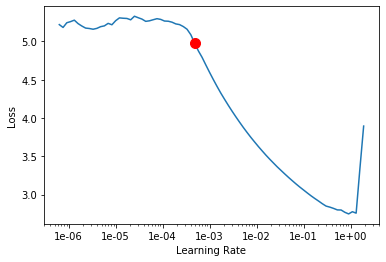

In [9]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [10]:
# Default to LR if lr_find() has not been run
try:
    lr = learner.recorder.min_grad_lr
except:
    lr = LR
lr

0.0004786300923226385

In [ ]:
learner.fit_one_cycle(EPOCHS, max_lr=lr, callbacks=[SAVE_CALLBACK(learner)])

epoch,train_loss,valid_loss,ctc_error,time
0,1.539776,1.960304,0.841610,09:08
1,1.539668,1.657411,0.910686,09:08
2,1.539710,1.582668,0.931015,09:07
3,1.539732,1.552890,0.949631,09:08
4,1.539555,1.542713,0.957888,09:07
5,1.539104,1.539147,0.960311,09:08
6,1.537900,1.541429,0.958440,09:08


## Predict

In [ ]:
x, y, _ = databunch.valid_dl.tensors
x_device = x.to(device=DEVICE)
y_pred = model(x_device).detach().cpu().numpy()

In [ ]:
r = range(min(5, DIMENSIONS_PREDICTION_OUT), min(DIMENSIONS_PREDICTION_OUT+1, 50)) #Range can't contain values larger than PRED_OUT_DIM

for index in [0, BS-1]:
    actual = pop.convert_idx_to_base_sequence(y[index], ALPHABET_VAL)
    prediction = y_pred[index]
    for pred, beam, error in g.get_stats(prediction, actual, ALPHABET_STR, r):
        print(pred, beam, error.error)
    print('')

In [ ]:
# Run assemble only if data is not fetched from featherfile
# TODO: Assembled should not be on a batch, but instead on a complete signal
if STRIDE != WINDOW_SIZE:
    decoded = pop.decode(y_pred, ALPHABET_STR, beam_size=15)
    assembled = pop.assemble(decoded, WINDOW_SIZE, STRIDE, ALPHABET)
    print('Assembled:', assembled)